In [1]:
import random

from torch import nn
from torch.optim import AdamW
import torchmetrics
from transformers import RobertaTokenizerFast, AutoModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from batch_doc_pipeline import *

random.seed(42)
reshuffle_docs = False

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

batch_size = 10 # documents
learning_rate = 2e-4
n_epochs = 20

type = 'Quantity'

model_name = 'allenai/biomed_roberta_base'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

data_size_reduce = .05 # multiplier for making small datasets

run_config =  {
    
}

In [2]:
class OurBERTModel(nn.Module):
    def __init__(self):
        super(OurBERTModel, self).__init__()
        self.mod = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, 2)

    def forward(self, text, att_mask):
        b, num_tokens = text.shape
        token_type = torch.zeros((b, num_tokens), dtype=torch.long).to(device)
        outputs = self.mod(text, attention_mask=att_mask, token_type_ids=token_type)
        return self.classifier(self.drop(outputs['last_hidden_state']))

model = OurBERTModel()

print(sum(p.numel() for p in model.parameters()),"parameters!")
model = model.to(device)
print("Detected", torch.cuda.device_count(), "GPUs!")

Some weights of the model checkpoint at allenai/biomed_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


124647170 parameters!
Detected 1 GPUs!


In [3]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)
f1_f = torchmetrics.F1Score(mdmc_average='samplewise')
acc_f = torchmetrics.Accuracy(mdmc_average='samplewise')

In [4]:
train_annot, dev_annot, test_annot, train_txt, dev_txt, test_txt = read_data(reshuffle_docs = reshuffle_docs)

train_docIds = list(set(train_annot['docId']))
dev_docIds = list(set(dev_annot['docId']))
test_docIds = list(set(test_annot['docId']))

In [5]:
########## Tokenizer ###########

tokenizer = RobertaTokenizerFast.from_pretrained(model_name)



In [6]:
################# TOKENIZE #################
train_docIds = random.sample(train_docIds, int(len(train_docIds)*data_size_reduce))

quant_train_dataset = tokenize_and_align_labels(
    docs_or_sents=train_docIds,
    txt=train_txt,
    annotation=train_annot,
    tokenizer=tokenizer)
num_train_docs = quant_train_dataset.shape[0]

dev_docIds = random.sample(dev_docIds, int(len(dev_docIds)*data_size_reduce))

quant_dev_dataset = tokenize_and_align_labels(
    docs_or_sents=dev_docIds,
    txt=dev_txt,
    annotation=dev_annot,
    tokenizer=tokenizer)
num_dev_docs = quant_dev_dataset.shape[0]

test_docIds = test_docIds

quant_test_dataset = tokenize_and_align_labels(
    docs_or_sents=test_docIds,
    txt=test_txt,
    annotation=test_annot,
    tokenizer=tokenizer)
num_test_docs = quant_test_dataset.shape[0]


In [7]:
quant_train_dataset.head()

,attention_mask,doc_or_sent_id,input_ids,labels
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0019103512003533-5300,"[0, 133, 5181, 1022, 19, 35235, 1007, 34903, 6...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0019103511004994-996,"[0, 24873, 4193, 8358, 35235, 24144, 14561, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S016412121300188X-4069,"[0, 1620, 41, 1246, 6, 5, 490, 1300, 37024, 42...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0012821X13002185-994,"[0, 133, 24573, 23808, 9, 31769, 46663, 16546,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0006322312001096-1221,"[0, 170, 11236, 27335, 20117, 230, 28732, 6, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
device

device(type='cuda')

In [9]:
################# batchify ####################
batched_quant_train_ds = batchify(quant_train_dataset, batch_size, device)
batched_quant_dev_ds = batchify(quant_dev_dataset, batch_size, device)
batched_quant_test_ds = batchify(quant_test_dataset, batch_size, device)


In [10]:
batched_quant_train_ds[0]

{'input_ids': tensor([[    0,   133,  5181,  ...,     1,     1,     1],
         [    0, 24873,  4193,  ...,     1,     1,     1],
         [    0,  1620,    41,  ...,     1,     1,     1],
         ...,
         [    0,   133, 34255,  ...,     1,     1,     1],
         [    0,  1640,   500,  ...,     1,     1,     1],
         [    0, 48080,  4060,  ...,     1,     1,     1]], device='cuda:0'),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'doc_or_sent_id': ['S0019103512003533-5300',
  'S0019103511004994-996',
  'S016412121

In [11]:
def train_batch(ds):

    model.train()
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        output = model(input_ids, attention_mask)
        logits = output.permute(0,2,1)
        
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        predictions = torch.argmax(logits, dim=1)
        last = attention_mask[0].sum()
        y_pred = []
        y_true = []
        for i in range(predictions.shape[0]):
            last_tok = attention_mask[i].sum()-1
            y_pred.append(predictions[i][:last_tok].cpu().numpy())
            y_true.append(labels[i][:last_tok].cpu().numpy())

        y_true = np.concatenate(y_true).ravel()
        y_pred = np.concatenate(y_pred).ravel()

        progress_bar.update(1)
            
    return loss



def eval_batch(ds):
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            output = model(input_ids, attention_mask)
            logits = output.permute(0,2,1)
            
            loss = criterion(logits, labels)
            
            predictions = torch.argmax(logits, dim=1)
            y_pred = []
            y_true = []
            for i in range(predictions.shape[0]):
                last_tok = attention_mask[i].sum()-1
                y_pred.append(predictions[i][:last_tok].cpu().numpy())
                y_true.append(labels[i][:last_tok].cpu().numpy())

            y_true = np.concatenate(y_true).ravel()
            y_pred = np.concatenate(y_pred).ravel()

    return y_true, y_pred, loss

In [12]:
logger = {
    'train_batches':[],
    'train_losses':[],
    'eval_batches':[],
    'eval_losses':[],
}

num_epochs = n_epochs
num_training_steps = num_epochs * len(batched_quant_train_ds)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

loss_report = {'epoch':[],'train':[],'train_eval':[],'dev_eval':[]}

metrics_report = {} #### todo: complete this

for epoch in range(num_epochs):
    loss_report['epoch'].append(epoch)
    
    print(f"\n============ Begin Epoch {epoch+1} ============")

    loss = train_batch(batched_quant_train_ds)
    loss_report['train'].append(loss.detach().cpu().numpy())
    
    y_true_train, y_pred_train, loss = eval_batch(batched_quant_train_ds)
    print('Training Set Classification Report:')
    train_report = classification_report(y_true_train, y_pred_train,
                    target_names=[str('Not '+type),type],output_dict=True, zero_division=0)
    print(train_report[type])
    loss_report['train_eval'].append(loss.cpu().numpy())

    y_true_dev, y_pred_dev, loss = eval_batch(batched_quant_dev_ds)
    print('\nDev Set Classification Report:')
    dev_report = classification_report(y_true_dev, y_pred_dev,
                    target_names=[str('Not '+type),type],output_dict=True, zero_division=0)
    print(dev_report[type])
    loss_report['dev_eval'].append(loss.cpu().numpy())


  0%|          | 0/40 [00:00<?, ?it/s]


============ Begin Epoch 1 ============
Training Set Classification Report:
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 191}

Dev Set Classification Report:
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 124}

============ Begin Epoch 2 ============
Training Set Classification Report:
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 191}

Dev Set Classification Report:
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 124}

============ Begin Epoch 3 ============
Training Set Classification Report:
{'precision': 0.9252336448598131, 'recall': 0.518324607329843, 'f1-score': 0.6644295302013422, 'support': 191}

Dev Set Classification Report:
{'precision': 0.7021276595744681, 'recall': 0.2661290322580645, 'f1-score': 0.38596491228070173, 'support': 124}

============ Begin Epoch 4 ============
Training Set Classification Report:
{'precision': 0.9121621621621622, 'recall': 0.7068062827225131, 'f1-score': 0.7964601769911505, 'support

In [14]:
##### todo: save reports and results to files

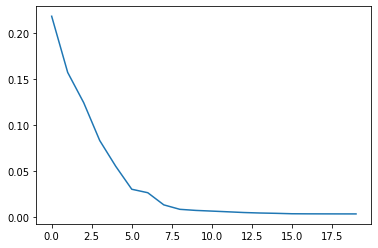

In [15]:
########################## training loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(loss_report['epoch'])))
y = np.array(loss_report['train_eval'])
plt.plot(x,y)
plt.show()

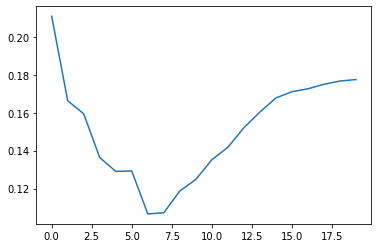

In [16]:
########################## eval loss plot #######################

x = np.array(range(len(loss_report['epoch'])))
y = np.array(loss_report['dev_eval'])
plt.plot(x,y)
plt.show()

In [17]:
###################### single batch training debugging ######################
# batch = batched_quant_train_ds[0]

# model.train()

# labels = batch['labels']
# # print(labels)
# input_ids = batch['input_ids']
# # print(input_ids)
# attention_mask = batch['attention_mask']
# # print(attention_mask)

# outputs = model(input_ids, attention_mask)
# logits = outputs

# train_loss = criterion(logits.permute(0,2,1), labels)

# train_loss.backward()
# optimizer.step()
# lr_scheduler.step()
# optimizer.zero_grad()

In [18]:
###################### single batch prediction debugging ######################

# batch = batched_quant_dev_ds[0]

# model.eval()

# with torch.no_grad():
#     labels = batch['labels']
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']

#     output = model(input_ids, attention_mask)
#     logits = output.permute(0,2,1)

#     loss = criterion(logits, labels)
#     logger['eval_losses'].append(loss.item())

#     predictions = torch.argmax(logits, dim=1)
#     accuracy = acc_f(labels,predictions).item()
#     print(accuracy)
#     f1 = f1_f(labels,predictions).item()
#     print(f1)

#     # labels = labels[0].cpu().numpy()
#     # predictions = predictions[0].cpu().numpy()

#     # confusion_matrix(labels,predictions[0].cpu().numpy())
# print(predictions.shape)
# print(attention_mask.shape)
# print(labels.shape)
# print(torch.sum(attention_mask[0]))
# # np.nonzero(attention_mask[0])[-1].item()
# last = attention_mask[0].sum()
# y_pred = []
# y_true = []
# for i in range(predictions.shape[0]):
#     last_tok = attention_mask[i].sum()-1
#     y_pred.append(predictions[i][:last_tok].cpu().numpy())
#     y_true.append(labels[i][:last_tok].cpu().numpy())

# y_true = np.concatenate(y_true).ravel()
# y_pred = np.concatenate(y_pred).ravel()

# y_true.shape
# y_pred.shape
# classification_report(y_true, y_pred, output_dict=True)['1']